# Proyecto Final: Radio Machine Learning Learning 2016.

**Autores:**  
* Jackeline Morales Hernandez

* Jose David Ortiz Miranda

**Tratamiento de Señales III**

**Facultad de Ingeniería**

**Universidad de Antioquia**

In [1]:
!gdown '1Yuj_rq3EEITslOQ0AHEl2HKzDovMQH3K'

Downloading...
From: https://drive.google.com/uc?id=1Yuj_rq3EEITslOQ0AHEl2HKzDovMQH3K
To: /content/RML2016.10a_dict.pkl
100% 641M/641M [00:07<00:00, 83.1MB/s]


In [2]:
import os,random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle, sys
%matplotlib inline
from tensorflow import keras
from keras.utils import to_categorical
import tensorflow.keras.models as models
from tensorflow.keras.layers import Reshape,Dense,Dropout,Activation,Flatten
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.regularizers import *
from tensorflow.keras.layers import Conv2D
from sklearn.preprocessing import LabelBinarizer
#from tensorflow.keras.optimizers import adam
from sklearn.metrics import classification_report

In [3]:
# Load the dataset ...
#  You will need to seperately download (radioml.com) or generate this file
with open("RML2016.10a_dict.pkl", 'rb') as f:
    Xd = pickle.load(f, encoding="latin1")

### ***Acceder con los keys a los dato se Xd que esta en formato Pickle***

In [4]:
# Calculate modulations and signal-to-noise ratios contained in dataset
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])

In [5]:
# print('These are the modulation schemes in the dataset: {}'.format(mods))
# print('These are the signal to noise ratios in the dataset: {}'.format(snrs))

## ***Función para reconstruccion de la señal, aplicando:***

$$\text{Modulated Carrier RF} = I \cos(2\pi ft) + Q \sin(2 \pi ft)$$

In [6]:
'''
Compute the original RF signal from the I & Q components.
'''
def reconstructSignal(s):
    I = s[0,:]   # I component
    Q = s[1,:]   # Q component
    n = len(I)   # number of samples
    f = 1e6     # Carrier frequency
    return I*np.cos(2*np.pi*f*np.arange(n)) + Q*np.sin(2*np.pi*f*np.arange(n))

### ***Se recorren todos los datos con todas la modulaciones y sus respectivas relaciones SNR***

In [7]:
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

### ***Se añade Ruido Blanco Gaussiano***

In [8]:
numNoiseSamples = 20000 # Add 20,000 samples of just Gaussian noise
for i in range(numNoiseSamples):
    lbl.append(['Noise', snrs[i%len(snrs)]])

mods.append('Noise')
X_noise = np.random.normal(0, 0.01, [numNoiseSamples, 2, 128])
X = np.concatenate((X, X_noise))  # Add noise to the end of the data

***Se distingue cada modulación como con un código binario***

In [9]:
lbl = np.array(lbl) # Convert from list to numpy array (for speed)

# This will encode the labels into a binary array.
# This is referred to as One-Hot.
# Each element of the array is either 1 or 0.
# The position of the element refers to which type of modulation.
# So if there are 11 modulation types, then the
# array is length 11.
# e.g.  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] codes '8PSK'
#       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0] codes 'AM-DSB'
#       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] codes 'WBFM'
# We'll use this to compare the output of the neural network
# and help train the model to give the lowest error (in this case
# the cost will be the cross-entropy).
y_encoded = LabelBinarizer().fit_transform(lbl[:,0])

# print(y_encoded.shape)


### ***Dividimos entre datos de entrenamiento y test***

In [10]:
# Partition the data
#  into training and test sets of the form we can train/test on
#  while keeping SNR and Mod labels handy for each
np.random.seed(2016)
n_examples = X.shape[0]
n_train = int(n_examples * 0.7)

# Now get a list of random indicies to sample for the training set
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)

# Testing set is whatever indicies are left over
test_idx = list(set(range(0,n_examples))-set(train_idx))

# Now split up the data by the random indicies
X_train = X[train_idx]
X_test =  X[test_idx]
Y_train = y_encoded[train_idx]
Y_test = y_encoded[test_idx]

#### ***Para ver los datos anteriormente sacados***

In [11]:
# print('Training set is {}'.format(np.shape(X_train)))
# print('Test set is {}'.format(np.shape(X_test)))

In [12]:
# in_shp = list(X_train.shape[1:])   # This is the input shape of 2 channels x 128 time samples
# print(X_train.shape, in_shp)
# classes = mods
#  print(classes)

# ***Tarea: Codificar al menos 2 arquitecturas neuronales para evaluar el reconocimiento de la modulación***

In [13]:
from keras import backend
img_rows, img_cols = 2, 128
'''
if backend.image_dim_ordering() == 'th':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
'''
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

print('X_train:', X_train.shape)
print('X_test:', X_test.shape)

X_train: (168000, 2, 128, 1)
X_test: (72000, 2, 128, 1)


### ***Se construye la red neuronal***

In [14]:
# Build CNN Neural Net model using tensorflow  --
#  - Reshape [N,2,128] to [N,2,128,1] on input
#  - Pass through 3 2DConv/ReLu layers
#  - Pass through 2 Dense layers (ReLu and Softmax)
#  - Perform categorical cross entropy optimization


dr = 0.6 # dropout rate (%) = percentage of neurons to randomly lose each iteration
model = models.Sequential()  # Neural network is a set of sequential layers
#model.add(Convolution2D(...))
# number of convolutional filters to use
nb_classes = 12

# size of pooling area for max pooling
pool_size = (2, 2)


model.add(Conv2D(16, (2, 8),padding='same',input_shape=input_shape,activation='relu',name='conv1'))
model.add(Conv2D(32, (1,3),activation='relu',padding='same',name='conv2'))
model.add(Conv2D(64, (1,3),activation='relu',padding='same',name='conv3'))
#model.add(MaxPooling2D(pool_size=pool_size,padding='same'))
model.add(Flatten(name='Flatten'))
model.add(Dense(units=128, activation='relu',name='Dense1'))
model.add(Dropout(dr,name='Drop1'))
model.add(Dense(units=nb_classes, activation='softmax',name='Dense2'))


print(model.summary())
# model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 2, 128, 16)        272       
                                                                 
 conv2 (Conv2D)              (None, 2, 128, 32)        1568      
                                                                 
 conv3 (Conv2D)              (None, 2, 128, 64)        6208      
                                                                 
 Flatten (Flatten)           (None, 16384)             0         
                                                                 
 Dense1 (Dense)              (None, 128)               2097280   
                                                                 
 Drop1 (Dropout)             (None, 128)               0         
                                                                 
 Dense2 (Dense)              (None, 12)                1

In [15]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

## ***Entrenando el modelo***

In [16]:
# Set up some params
nb_epoch = 100     # number of epochs to train on
batch_size = 1024  # training batch size
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = './'
modelWeightsFile = filepath + 'PESOS_TSIII.wts.h5'  # Save the model weights to this file

history = model.fit(X_train,
    Y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    verbose=2,
    validation_data=(X_test, Y_test),
    callbacks = [
        keras.callbacks.ModelCheckpoint(modelWeightsFile, monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
    ])

# we re-load the best weights once training is finished
model.load_weights(modelWeightsFile)

Epoch 1/100

Epoch 1: val_loss improved from inf to 1.88980, saving model to ./PESOS_TSIII.wts.h5
165/165 - 16s - loss: 2.2042 - accuracy: 0.2066 - val_loss: 1.8898 - val_accuracy: 0.3232 - 16s/epoch - 98ms/step
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 1.88980 to 1.76123, saving model to ./PESOS_TSIII.wts.h5
165/165 - 4s - loss: 1.8823 - accuracy: 0.3086 - val_loss: 1.7612 - val_accuracy: 0.3464 - 4s/epoch - 22ms/step
Epoch 3/100

Epoch 3: val_loss did not improve from 1.76123
165/165 - 3s - loss: 1.8246 - accuracy: 0.3252 - val_loss: 2.3425 - val_accuracy: 0.1847 - 3s/epoch - 20ms/step
Epoch 4/100

Epoch 4: val_loss improved from 1.76123 to 1.69571, saving model to ./PESOS_TSIII.wts.h5
165/165 - 4s - loss: 1.8888 - accuracy: 0.3038 - val_loss: 1.6957 - val_accuracy: 0.3710 - 4s/epoch - 21ms/step
Epoch 5/100

Epoch 5: val_loss improved from 1.69571 to 1.63663, saving model to ./PESOS_TSIII.wts.h5
165/165 - 4s - loss: 1.7538 - accuracy: 0.3471 - val_loss: 1.6366 - val_accuracy: 0.3928 - 4s/epoch - 21ms/step
Epoch 6/100

Epoch 6: val_loss improved from 1.63663 to 1.58413, saving model to ./PESOS_TSIII.wts.h5
165/165 - 4s - loss: 1.7165 - accuracy: 0.3610 - val_loss: 1.5841 - val_accuracy: 0.4129 - 4s/ep

## ***Evaluación del modelo***

In [17]:
# Supongamos que y_predict es tu array de predicciones y Y_test es tu conjunto de etiquetas reales
y_predict = model.predict(X_test,verbose=0)
y_pred=np.argmax(y_predict, axis=1)
y_test=np.argmax(Y_test, axis=1)
report = classification_report(y_test,y_pred,target_names=mods)

print(report)

              precision    recall  f1-score   support

        8PSK       0.26      0.08      0.13      5957
      AM-DSB       0.51      0.48      0.49      5852
      AM-SSB       0.25      0.91      0.39      5932
        BPSK       0.80      0.59      0.68      6051
       CPFSK       0.78      0.57      0.66      5963
        GFSK       0.76      0.59      0.66      6022
        PAM4       1.00      1.00      1.00      6125
       QAM16       0.92      0.64      0.75      5991
       QAM64       0.42      0.25      0.32      5906
        QPSK       0.55      0.50      0.53      6029
        WBFM       0.48      0.47      0.48      6072
       Noise       0.48      0.32      0.38      6100

    accuracy                           0.54     72000
   macro avg       0.60      0.53      0.54     72000
weighted avg       0.60      0.54      0.54     72000



## ***Curvas de pérdida***

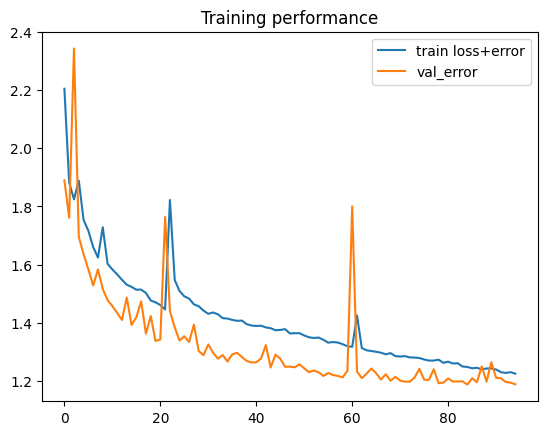

In [18]:
# Show loss curves
plt.figure();
plt.title('Training performance');
plt.plot(history.epoch, history.history['loss'], label='train loss+error');
plt.plot(history.epoch, history.history['val_loss'], label='val_error');
plt.legend();

## ***Matriz de confusión***

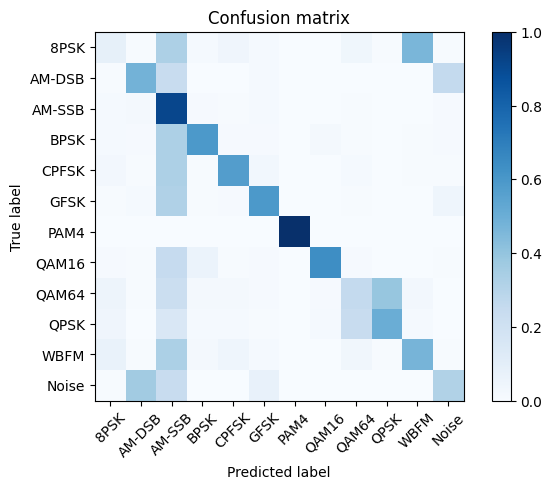

In [19]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
in_shp = list(X_train.shape[1:])   # This is the input shape of 2 channels x 128 time samples
classes = mods
test_Y_hat = model.predict(X_test, batch_size=batch_size,verbose=0)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)


Overall Accuracy for SNR -20: 0.16736518580609108
Overall Accuracy for SNR -18: 0.17779008584879535
Overall Accuracy for SNR -16: 0.18010385351188848
Overall Accuracy for SNR -14: 0.1823951434878587
Overall Accuracy for SNR -12: 0.21303395399780942
Overall Accuracy for SNR -10: 0.25773195876288657
Overall Accuracy for SNR -8: 0.361323155216285
Overall Accuracy for SNR -6: 0.4741113909879653
Overall Accuracy for SNR -4: 0.599218531956461
Overall Accuracy for SNR -2: 0.6696083838940982
Overall Accuracy for SNR 0: 0.7263069611406207
Overall Accuracy for SNR 2: 0.7374474053295933
Overall Accuracy for SNR 4: 0.7456115909724157
Overall Accuracy for SNR 6: 0.7374378796245168
Overall Accuracy for SNR 8: 0.7405647190383002
Overall Accuracy for SNR 10: 0.7509695290858726
Overall Accuracy for SNR 12: 0.7564461883408071
Overall Accuracy for SNR 14: 0.760056258790436
Overall Accuracy for SNR 16: 0.7444107093568866
Overall Accuracy for SNR 18: 0.7405133928571429


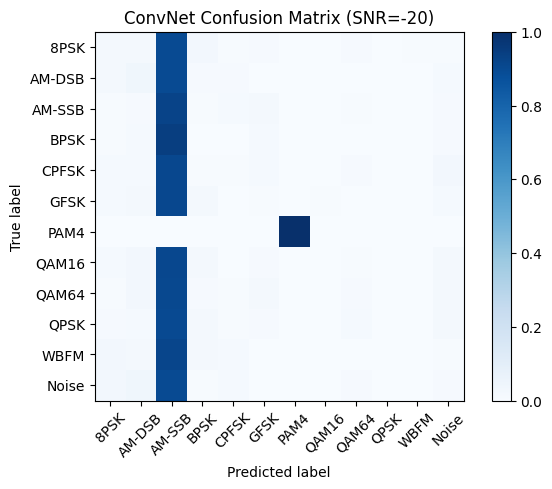

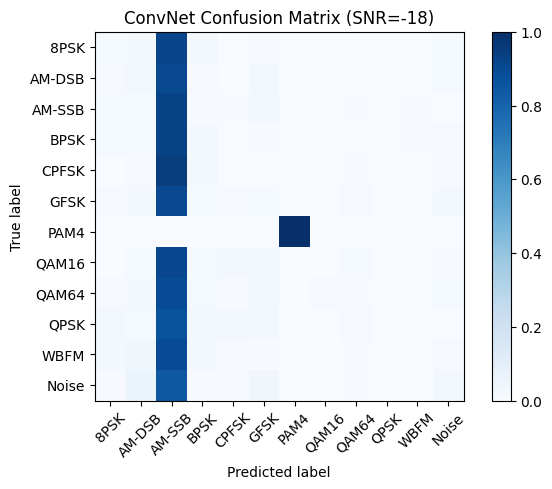

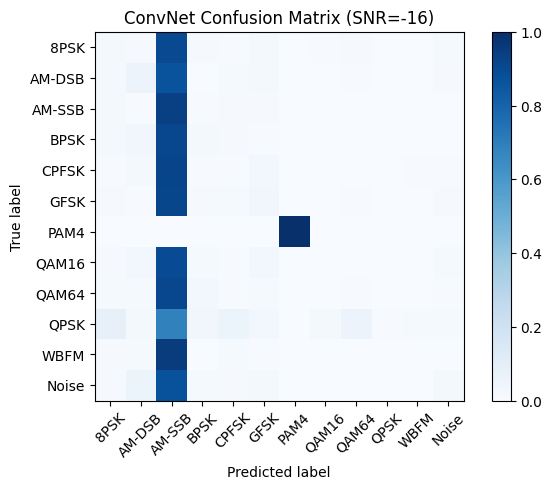

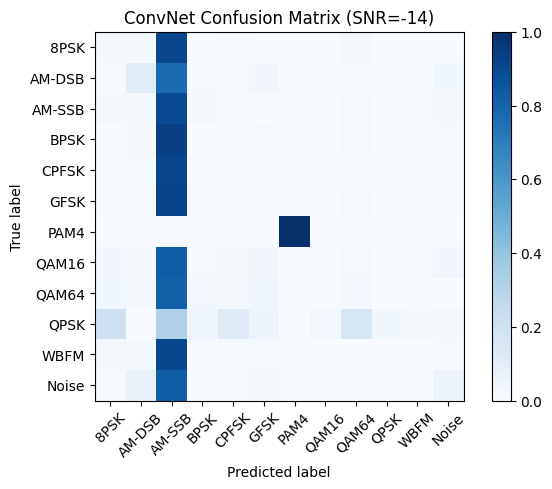

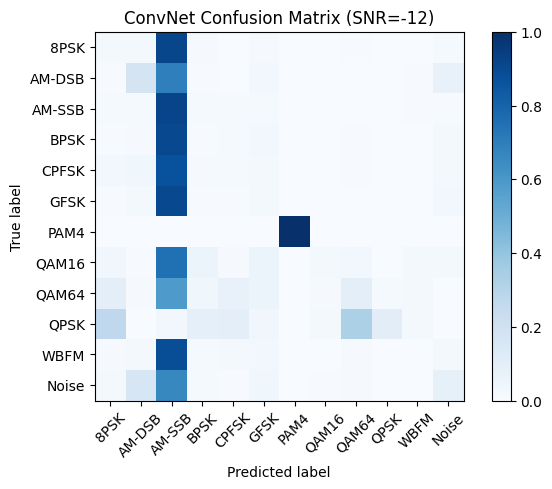

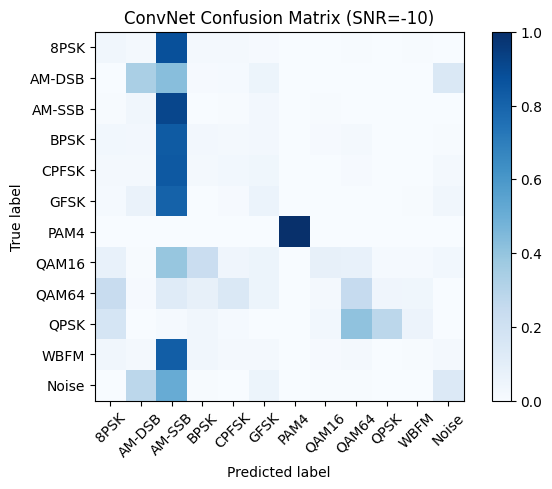

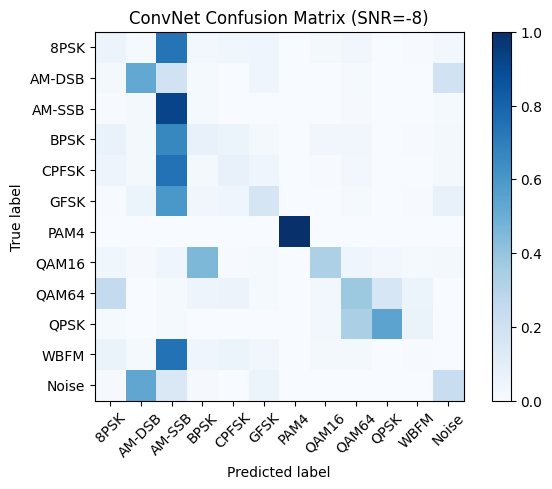

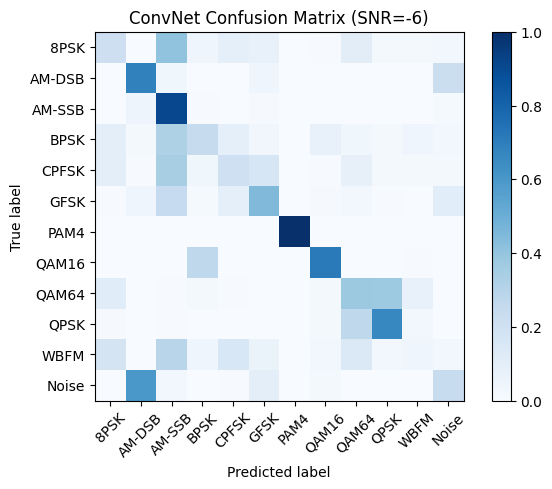

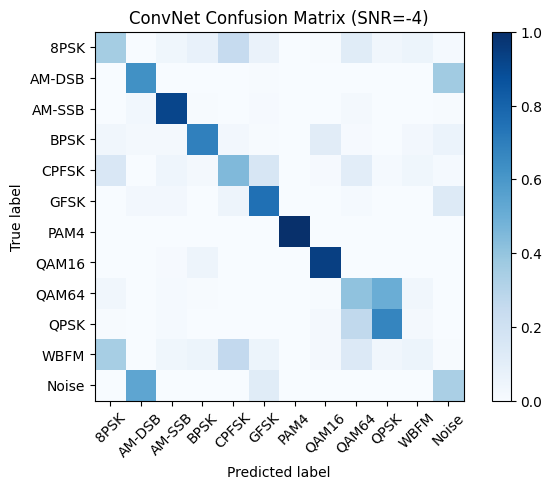

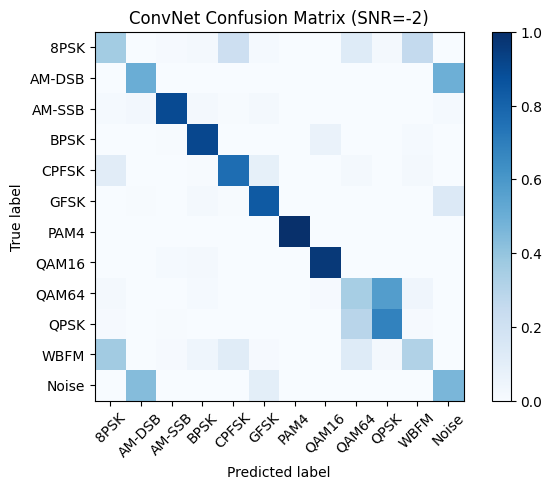

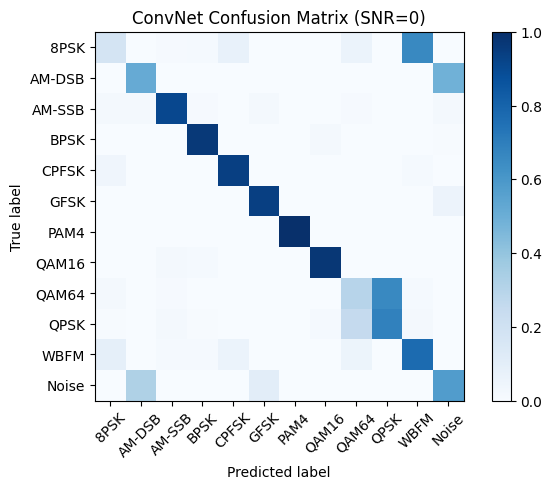

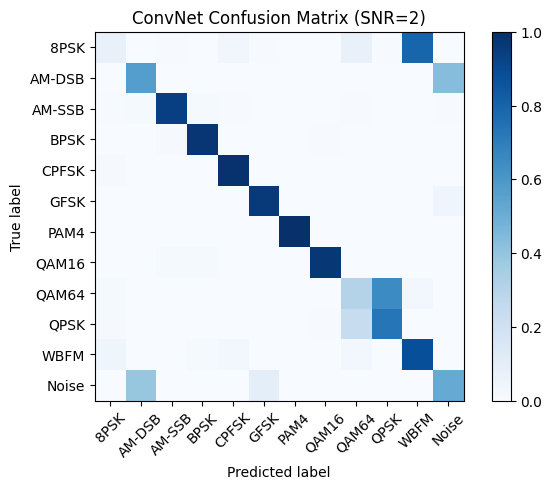

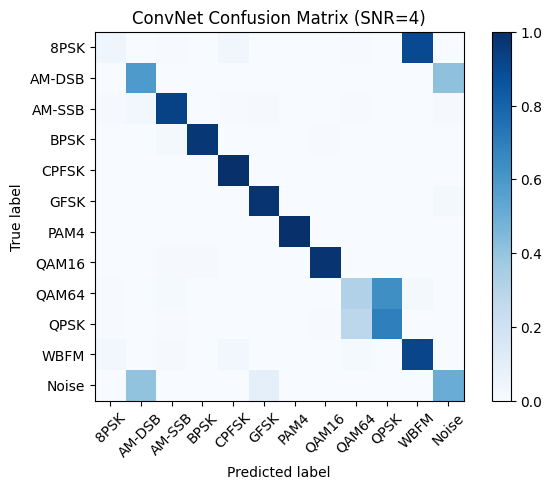

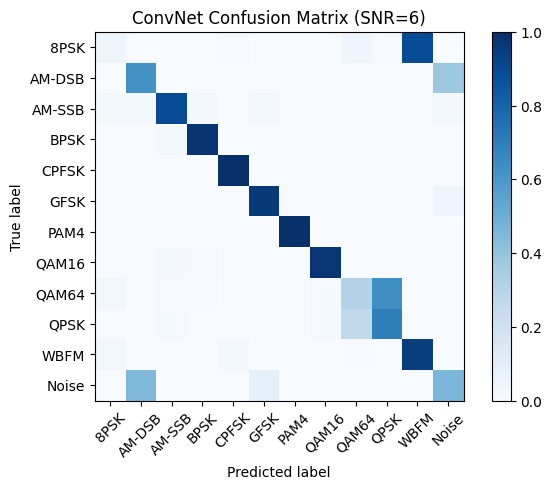

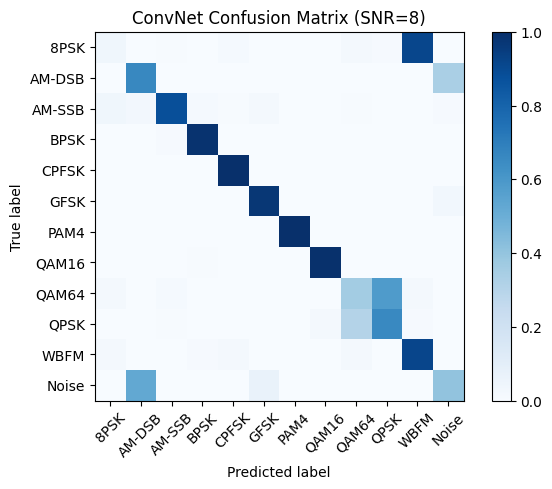

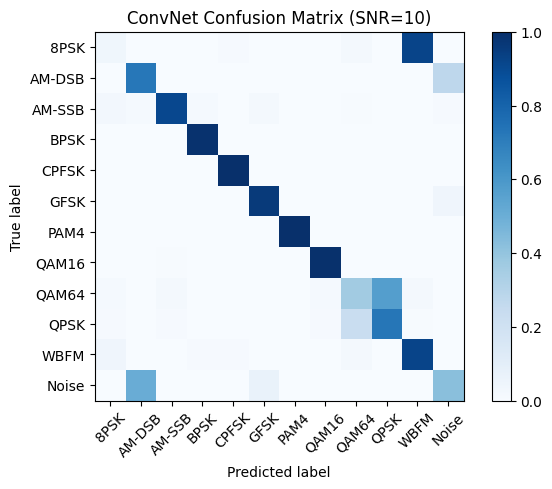

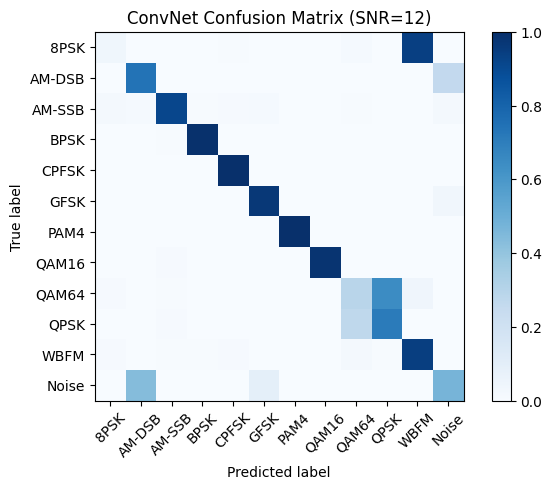

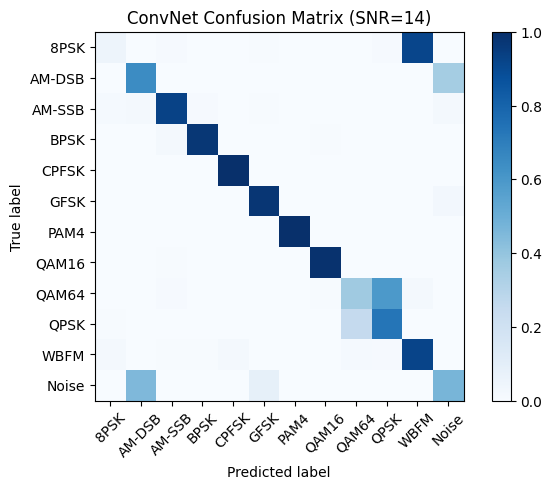

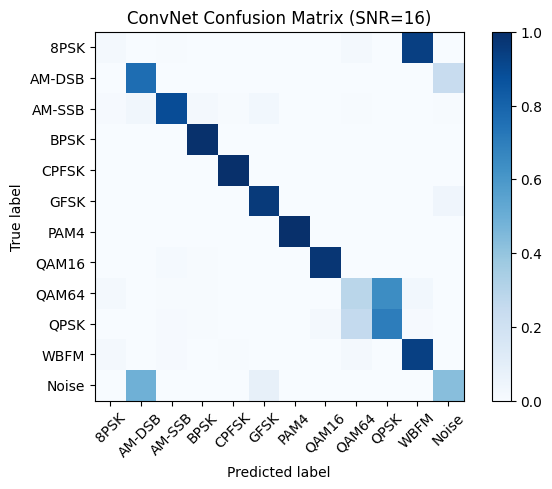

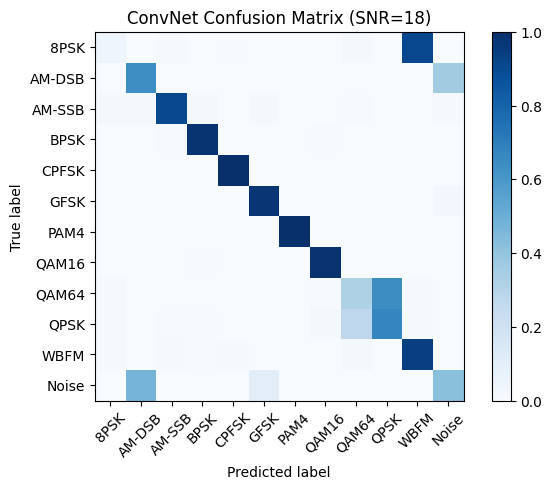

In [20]:
# Plot confusion matrix
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = map(lambda x: int(lbl[x][1]), test_idx)
    test_S = []
    for i in test_SNRs:
      test_S.append(i)
    test_S = np.array(test_S)
    test_X_i = X_test[np.where(test_S == snr)]
    test_Y_i = Y_test[np.where(test_S == snr)]
    # estimate classes
    test_Y_i_hat = model.predict(test_X_i,verbose=0)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))

    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy for SNR {}: {}".format(snr, cor / (cor+ncor)))
    acc[snr] = 1.0*cor/(cor+ncor)

## ***Curva de precisión***

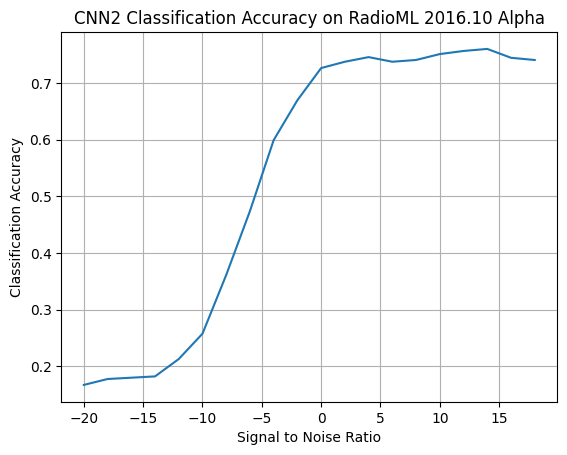

In [21]:
# Plot accuracy curve
plt.plot(snrs, list(map(lambda x: acc[x], snrs)))
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("CNN2 Classification Accuracy on RadioML 2016.10 Alpha")
plt.grid()
plt.show()
